# Importing Libraries


In [1]:
from wfield import *
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
import h5py
from scipy.ndimage import label
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator



# Defining functions

In [2]:
# def list_scans(data_folder, keyword):
#     # Find folders containing the keyword
#     scan_folders = [folder for folder in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, folder)) and keyword in folder]

#     # Print list of found folders
#     print(f"Folders containing '{keyword}' keyword:")
#     for i, folder in enumerate(scan_folders):
#         print(f"{i + 1}. {folder}")

#     # Prompt user to choose a folder
#     while True:
#         choice = input("Enter the number of the scan you want to choose: ")
#         if choice.isdigit() and 1 <= int(choice) <= len(scan_folders):
#             chosen_folder = scan_folders[int(choice) - 1]
#             break
#         else:
#             print("Invalid input. Please enter a valid number.")
#     print("Selected",chosen_folder)
#     # Return the path to the chosen folder
#     return os.path.join(data_folder, chosen_folder), chosen_folder


In [3]:
# import os

def list_scans(data_folder, keyword):
    # Find folders containing the keyword and get their creation time
    scan_folders = [(folder, os.stat(os.path.join(data_folder, folder)).st_ctime) for folder in os.listdir(data_folder) 
                    if os.path.isdir(os.path.join(data_folder, folder)) and keyword in folder]

    # Sort folders by creation time, newest first
    scan_folders.sort(key=lambda x: x[1], reverse=True)

    # Extract folder names for display
    scan_folder_names = [folder[0] for folder in scan_folders]

    # Print list of found folders
    print(f"Folders containing '{keyword}' keyword:")
    for i, folder in enumerate(scan_folder_names):
        print(f"{i + 1}. {folder}")

    # Prompt user to choose a folder
    while True:
        choice = input("Enter the number of the scan you want to choose: ")
        if choice.isdigit() and 1 <= int(choice) <= len(scan_folder_names):
            chosen_folder = scan_folder_names[int(choice) - 1]
            break
        else:
            print("Invalid input. Please enter a valid number.")
    
    print("Selected", chosen_folder)
    # Return the path to the chosen folder
    return os.path.join(data_folder, chosen_folder), chosen_folder


In [4]:
def demultiplex(auxdata, channels=5):
    """Demultiplex the digital data"""
    auxdata = auxdata.flatten()
    binary = [[int(x) for x in f'{x:0{channels}b}'] for x in auxdata]
    return np.array(binary, dtype=bool).T

In [5]:
def find_event_sizes(signal):
    event_sizes = []
    event_positions = []
    trialON_idx = []
    rewards_idx = []
    event_start = None

    for i, val in enumerate(signal):
        if val == 1 and event_start is None:
            event_start = i
        elif val == 0 and event_start is not None:
            event_duration = i - event_start
            event_sizes.append(event_duration)
            if event_duration > 10:
                rewards_idx.append((event_start, i))
            else:
                trialON_idx.append((event_start, i))
            # event_positions.append((event_start, i))
            event_start = None

    if event_start is not None:  # Handle case where the last event goes till the end
        event_duration = len(signal) - event_start
        event_sizes.append(event_duration)
        event_positions.append((event_start, len(signal)))
    
    return event_sizes, trialON_idx,rewards_idx

In [6]:
def list_bpod(localdisk):
    import scipy.io
    mat_files = glob(pjoin(localdisk,'*.mat'))
    if len(mat_files) > 1:
        print("Multiple Bpod files found:")
        for i, mat_file in enumerate(mat_files):
            print(f"{i + 1}. {os.path.basename(mat_file)}")
        
        while True:
            choice = input("Enter the number of the .dat file you want to choose: ")
            if choice.isdigit() and 1 <= int(choice) <= len(mat_files):
                mat_path = mat_files[int(choice) - 1]
                break
            else:
                print("Invalid input. Please enter a valid number.")
    elif len(mat_files) == 1:
        mat_path = mat_files[0]
        print("Bpod file found")
        print("Loading...")
    else:
        print("Bpod file not found")
        print("-----------------------")
    
    try:
        bpod_data = scipy.io.loadmat(mat_path)
        print("Selected", os.path.basename(mat_path))
    except:
        print("Failed")
    return bpod_data


In [7]:
# Load the HDF5 file and read the necessary datasets
def load_h5_data(h5_path):
    with h5py.File(h5_path, 'r') as f:
        sweep_data_key = list(f.keys())[1]
        sweep_data = f[sweep_data_key]
        header = f['header']

        AIChannelNames = header['AIChannelNames'][:]
        DIChannelNames = header['DIChannelNames'][:]
        YLimitsPerAIChannel = header['YLimitsPerAIChannel'][:]
        AIChannelNames = [name.decode('utf-8') for name in AIChannelNames]
        DIChannelNames = [name.decode('utf-8') for name in DIChannelNames]
        SampleRate = header['AcquisitionSampleRate'][:]

        analogData = sweep_data['analogScans'][:]
        digitalData = sweep_data['digitalScans'][:]

        return AIChannelNames, DIChannelNames, SampleRate[0, 0], analogData, digitalData

# Convert analogData and digitalData to DataFrame
def create_dataframe(ai_channel_names, di_channel_names, sample_rate, analog_data, digital_data):
    # Create DataFrame for analog data
    df_analog = pd.DataFrame(analog_data.T, columns=ai_channel_names)

    # Create DataFrame for digital data
    df_digital = pd.DataFrame(digital_data.T, columns=di_channel_names)

    # Concatenate analog and digital data
    df = pd.concat([df_analog, df_digital], axis=1)

    # Add time column
    df['time_seconds'] = df.index / sample_rate

    return df

In [8]:
def extract_trials(data, idx_list, pre_window, post_window):
    trials = []
    for start, end in idx_list:
        trial_start = max(0, start - pre_window)
        trial_end = min(len(data), end + post_window)
        trial_data = data[trial_start:trial_end]
        trials.append(trial_data)
    return trials

# Reading Aux file

In [9]:
data_folder = r'/datajoint-data/data/aeltona/'
localdisk, scan_idx = list_scans(data_folder,"AA")

Folders containing 'AA' keyword:
1. AudPassProbe_AA_ROS-1792_2024-06-15_scan9FOMVAUF_sess9FOMVAUF
2. AudPassCond_AA_ROS-1792_2024-06-15_scan9FOMVTU6_sess9FOMVAUF
3. PassProbe_AA_ROS-1783_2024-06-13_scan9FOLMV1H_sess9FOLMV1H
4. PassAudCond_AA_ROS-1783_2024-06-13_scan9FOLNSC0_sess9FOLNSC0
5. AtivConditioning_AA_ROS-1792_2024-06-14_scan9FOM3HZ3_sess9FOM3HZ3
6. PassAudCond_AA_ROS-1783_2024-06-14_scan9FOM4GU6_sess9FOM4GU6
7. PassConditioning_AA_ROS-1792_2024-06-11_scan9FOKEEYA_sess9FOKEEYA
8. PassConditioning_AA_ROS-1792_2024-06-13_scan9FOLLVZB_sess9FOLLVZB
9. AtivConditioning_AA_ROS-1792_2024-06-13_scan9FOLMDEP_sess9FOLLVZB
10. AtivConditioning_AA_ROS-1792_2024-06-11_scan9FOKELLL_sess9FOKEEYA
11. AudProbe_AA_ROS-1783_2024-06-12_scan9FOKYSB7_sess9FOKYSB7
12. PassConditioning_AA_ROS-1792_2024-06-11_scan9FOKEWPU_sess9FOKEEYA
13. AudProbe_AA_ROS-1783_2024-06-12_scan9FOKZ1AY_sess9FOKYSB7
14. AtivConditioning_AA_ROS-1783_2024-06-11_scan9FOKFXB0_sess9FOKFXB0
15. PassConditioning_AA_ROS-1792_2024-

In [10]:
h5_path = glob(pjoin(localdisk,'*.h5'))[0]
h5_path

'/datajoint-data/data/aeltona/AudPassCond_AA_ROS-1792_2024-06-15_scan9FOMVTU6_sess9FOMVAUF/scan9FOMVTU6_AudPassCond_AudPassCond_AA_ROS-1792_0001.h5'

In [13]:

# Open the HDF5 file
with h5py.File(h5_path, 'r') as f:
    sweep_data_key = list(f.keys())[1]
    # print(sweep_data_key)
    sweep_data = f[sweep_data_key]
    # print(sweep_data.keys())
    header = f['header'] 
    # print(header.keys())    
    AIChannelNames = header['AIChannelNames'][:]
    DIChannelNames = header['DIChannelNames']
    DIChannelTerminalIDs = header['DIChannelTerminalIDs'][:]
    YLimitsPerAIChannel = header['YLimitsPerAIChannel'][:]
    AIChannelNames = [name.decode('utf-8') for name in AIChannelNames]
    DIChannelNames = [name.decode('utf-8') for name in DIChannelNames]
    SampleRate = header['AcquisitionSampleRate'][:]
    analogData = sweep_data['analogScans'][:]
    digitalData = sweep_data['digitalScans'][:]

In [14]:
DIChannelNames

['FakeReward', 'VisStim_ON']

In [15]:
sampling_rate_hz = int(SampleRate[0,0])


In [16]:
# Convert analogData to DataFrame
df = pd.DataFrame(analogData.T, columns=AIChannelNames)
sampling_rate_hz = int(SampleRate[0,0])
df['time_seconds'] = df.index / sampling_rate_hz
# Print DataFrame
# print(df)
df.columns

Index(['camera_trigger', 'blue_470nm', 'violet_405nm', 'HIFI', 'Reward',
       'TrialTypeON', 'Licks', 'Rotary Encoder', 'time_seconds'],
      dtype='object')

## Digital channels

In [17]:
DIChannelNames

['FakeReward', 'VisStim_ON']

In [18]:
digital_scans = demultiplex(digitalData[0], len(DIChannelNames))


In [19]:
digital_scans.shape

(2, 69088640)

In [34]:
df[DIChannelNames[0]] = digital_scans[1]
df[DIChannelNames[1]] = digital_scans[0]

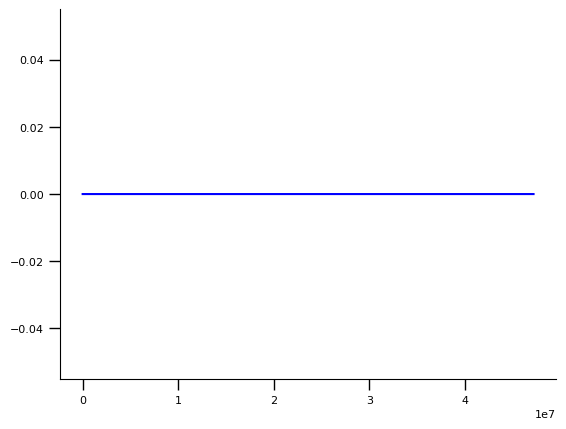

In [33]:
# df['HIFI_norm']= df["HIFI"] / df["HIFI"].max()

# plt.plot(digital_scans[0],c="blue");
# plt.plot(digital_scans[1],c='red');
# plt.plot(df['HIFI_norm'],c='black');
# plt.plot(digital_scans[1]);

## Licks

In [16]:
norm_TrialON_FRew = (df['TrialON_FRew'] - df['TrialON_FRew'].min()) / (df['TrialON_FRew'].max() - df['TrialON_FRew'].min())
norm_TrialON_FRew = norm_TrialON_FRew.round(0)
norm_Rew_StimON = (df['Reward'] - df['Reward'].min()) / (df['Reward'].max() - df['Reward'].min())
norm_Rew_StimON = norm_Rew_StimON.round(0)
norm_licks = (df['Lick Count'] - df['Lick Count'].min()) / (df['Lick Count'].max() - df['Lick Count'].min())
norm_licks = norm_licks.round(0)

In [35]:

try:
    norm_TrialON_FRew = (df['TrialON_FRew'] - df['TrialON_FRew'].min()) / (df['TrialON_FRew'].max() - df['TrialON_FRew'].min())
    norm_TrialON_FRew = norm_TrialON_FRew.round(0)
    norm_Rew_StimON = (df['Rew_StimON'] - df['Rew_StimON'].min()) / (df['Rew_StimON'].max() - df['Rew_StimON'].min())
    norm_Rew_StimON = norm_Rew_StimON.round(0)
    norm_licks = (df['Lick Count'] - df['Lick Count'].min()) / (df['Lick Count'].max() - df['Lick Count'].min())
    norm_licks = norm_licks.round(0)
except:
    # norm_TrialON_FRew = (df['FakeReward'] - df['FakeReward'].min()) / (df['FakeReward'].max() - df['FakeReward'].min())
    # try:
        norm_TrialON_FRew = df['FakeReward']
        norm_licks = (df['Licks'] - df['Licks'].min()) / (df['Licks'].max() - df['Licks'].min())
        norm_licks = norm_licks.round(0)
    # except:
        norm_Rew_StimON = (df['Reward'] - df['Reward'].min()) / (df['Reward'].max() - df['Reward'].min())
        norm_Rew_StimON = norm_Rew_StimON.round(0)
        


In [36]:
event_sizes, trialON_idx, rews_idx  = find_event_sizes(norm_Rew_StimON)

print("Event sizes:", np.unique(event_sizes))
print("Length of trialON_idx:", len(trialON_idx))
print("Length of rews_idx:", len(rews_idx))

Event sizes: [5250]
Length of trialON_idx: 0
Length of rews_idx: 20


In [37]:
event_sizes, trialON_idx, frews_idx  = find_event_sizes(norm_TrialON_FRew)

print("Event sizes:", np.unique(event_sizes))
print("Length of trialON_idx:", len(trialON_idx))
print("Length of frews_idx:", len(frews_idx))

Event sizes: [5250 5251]
Length of trialON_idx: 0
Length of frews_idx: 85


In [38]:
# Create arrays for trial onsets and rewards
trial_onsets = np.zeros_like(norm_TrialON_FRew)
frews = np.zeros_like(norm_TrialON_FRew)
rews = np.zeros_like(norm_Rew_StimON)

for start, end in trialON_idx:
    trial_onsets[start:end] = 1

for start, end in frews_idx:
    frews[start:end] = 1

for start, end in rews_idx:
    rews[start:end] = 1

In [39]:
pre_window = int(5 * sampling_rate_hz)  # 5 seconds before
post_window = int(10 * sampling_rate_hz)  # 10 seconds after

frews_trials = extract_trials(norm_licks, frews_idx, pre_window, post_window)
rews_trials = extract_trials(norm_licks, rews_idx, pre_window, post_window)


In [40]:
filename_parts = re.split(r'_|\.', scan_idx)
scan_info = '_'.join(filename_parts[0:5])
scan_info

'Habituation_AA_ROS-1792_2024-06-04_scan9FOG9RQH'

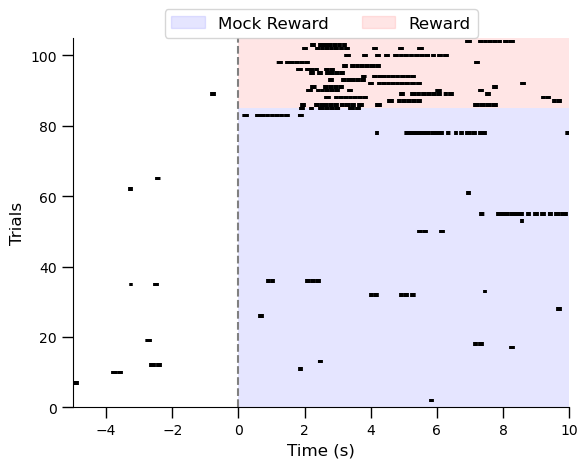

In [42]:
# Constants for time adjustment
pre_time_seconds = 5  # 5 seconds before the onset
post_time_seconds = 10  # 10 seconds after the onset

# Convert these times to index offsets
pre_index = pre_time_seconds * sampling_rate_hz
post_index = post_time_seconds * sampling_rate_hz

# Calculate total number of points to display
total_points = pre_index + post_index

# Adjust pre_window and post_window according to the onset index and total points
pre_window = 100000 - pre_index  # Adjusted to start 5s before the onset
post_window = 100000 + post_index  # Adjusted to end 10s after the onset

# Time conversion for x-axis (from indices to seconds, centered at onset)
time_axis = np.linspace(-pre_time_seconds, post_time_seconds, total_points)

# Adjust event plotting to reflect new time_axis
for i, trial in enumerate(frews_trials):
    events = np.where(trial)[0]
    valid_events = events[(events >= pre_window) & (events < post_window)] - 100000
    plt.eventplot(time_axis[valid_events + pre_index], lineoffsets=i, colors='black')

offset = len(frews_trials)
for i, trial in enumerate(rews_trials):
    events = np.where(trial)[0]
    valid_events = events[(events >= pre_window) & (events < post_window)] - 100000
    plt.eventplot(time_axis[valid_events + pre_index], lineoffsets=i + offset, colors='black')


num_frews_trials = len(frews_trials)
num_rews_trials = len(rews_trials)
total_trials = num_frews_trials + num_rews_trials

# Shading for frews_trials
for i in range(num_frews_trials):
    ymin = i / total_trials  # Adjust ymin based on total trials count
    ymax = (i + 1) / total_trials  # Adjust ymax similarly
    plt.axvspan(0, 10, facecolor='blue', alpha=0.1, ymin=ymin, ymax=ymax)

# Shading for rews_trials
for i in range(num_rews_trials):
    ymin = (i + num_frews_trials) / total_trials  # Start from the end of frews_trials
    ymax = (i + 1 + num_frews_trials) / total_trials
    plt.axvspan(0, 10, facecolor='red', alpha=0.1, ymin=ymin, ymax=ymax)

mock_reward_patch = patches.Patch(color='blue', alpha=0.1, label='Mock Reward')
reward_patch = patches.Patch(color='red', alpha=0.1, label='Reward')

# Update formatting
plt.xlabel('Time (s)')
plt.ylabel('Trials')
# plt.title('Raster Plot of Lick Events')
plt.axvline(0, color='grey', linestyle='--')  # Indicate the stimulus onset
plt.xlim([-5, 10])  # Set x-axis limits to -5s to 10s
plt.ylim(0,total_trials)

# Adjust tick label size
plt.xticks(fontsize=10)  # Adjust tick font size as needed
plt.yticks(fontsize=10)  # Adjust tick font size as needed

plt.legend(handles=[mock_reward_patch, reward_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

# Construct the path to the folder where the plot will be saved
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Licks')
file_path = os.path.join(folder_path, f'{scan_info}_licks')

# Check if the folder exists, and create it if it does not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
# Save and show plot (make sure 'folder_path' and 'file_path' are correctly defined)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
plt.savefig(f'{file_path}.svg')
plt.savefig(f'{file_path}.png')
plt.show()

In [ ]:
df['trial_onsets'] = trial_onsets
df['norm_licks'] = norm_licks
df['rews'] = rews
df['frews'] = frews
df.columns

Index(['camera_trigger', 'blue_470nm', 'violet_405nm', 'HIFI', 'Rew_StimON',
       'TrialON_FRew', 'Lick Count', 'Rotary Encoder', 'time_seconds',
       'trial_onsets', 'norm_licks', 'rews', 'frews'],
      dtype='object')

# Reading Bpod Data


In [134]:
data_folder = r'/datajoint-data/data/aeltona/'
localdisk, scan_idx = list_scans(data_folder,"AA")

Folders containing 'AA' keyword:
1. AudPassProbe_AA_ROS-1792_2024-06-15_scan9FOMVAUF_sess9FOMVAUF
2. AudPassCond_AA_ROS-1792_2024-06-15_scan9FOMVTU6_sess9FOMVAUF
3. PassProbe_AA_ROS-1783_2024-06-13_scan9FOLMV1H_sess9FOLMV1H
4. PassAudCond_AA_ROS-1783_2024-06-13_scan9FOLNSC0_sess9FOLNSC0
5. AtivConditioning_AA_ROS-1792_2024-06-14_scan9FOM3HZ3_sess9FOM3HZ3
6. PassAudCond_AA_ROS-1783_2024-06-14_scan9FOM4GU6_sess9FOM4GU6
7. PassConditioning_AA_ROS-1792_2024-06-11_scan9FOKEEYA_sess9FOKEEYA
8. PassConditioning_AA_ROS-1792_2024-06-13_scan9FOLLVZB_sess9FOLLVZB
9. AtivConditioning_AA_ROS-1792_2024-06-13_scan9FOLMDEP_sess9FOLLVZB
10. AtivConditioning_AA_ROS-1792_2024-06-11_scan9FOKELLL_sess9FOKEEYA
11. AudProbe_AA_ROS-1783_2024-06-12_scan9FOKYSB7_sess9FOKYSB7
12. PassConditioning_AA_ROS-1792_2024-06-11_scan9FOKEWPU_sess9FOKEEYA
13. AudProbe_AA_ROS-1783_2024-06-12_scan9FOKZ1AY_sess9FOKYSB7
14. AtivConditioning_AA_ROS-1783_2024-06-11_scan9FOKFXB0_sess9FOKFXB0
15. PassConditioning_AA_ROS-1792_2024-

In [128]:
bpod_data = list_bpod(localdisk)

Bpod file found
Loading...
Selected scan9FOMVTU6_AudPassCond_ROS-1792_SensoryPreconditioning_20240615_192951.mat


# Outcome plot

In [129]:
states_list = ['Hit', 'Anticipatory_Hit','Miss','Anticipatory_Miss']
# states_list = ['BufferHit', 'Anticipatory_Hit','BufferMiss','Anticipatory_Miss']

trials = bpod_data['SessionData'][0, 0]['RawEvents']['Trial'][0,0]

# Lists to hold the DataFrame data
num_trials = []
trial_types = []
outcomes = []

# Loop through each trial
for trial in range(trials.shape[1]):
    trial_data = trials[0, trial]
    trial_type = bpod_data['SessionData'][0][0]['TrialTypes'][0, trial]
    states = trial_data['States'][0,0]  # Assuming this mimics your data structure for states
    outcome = None  # Initialize outcome as None to handle cases where no state is valid

    for state in states_list:
        # Example of accessing state data; replace with actual way to access your 'states' data
        # Assuming there is a dictionary-like access needed here; you need to adjust this line according to your data structure
        # state_data = np.array([np.nan, np.nan])  # Placeholder for state data; replace with actual data access

        # Check if there is any valid state data
        if not np.isnan(states[state][0,0]).any():  # Corrected to check all elements
            # if state == 'Hit':
            #     outcome = 2
            if state == 'Hit':
                outcome = 2
            elif state == 'Anticipatory_Hit':
                outcome = 1
            elif state == 'Miss':
                outcome = -1
            elif state == 'Anticipatory_Miss':
                outcome = 0
            break  # Break the loop if a valid state has been found

    if outcome is None:
        print("No valid state found for trial", trial + 1)

    # Collect data for DataFrame
    num_trials.append(trial + 1)
    trial_types.append(trial_type)
    outcomes.append(outcome)



In [130]:
# Create the DataFrame
outcome_df = pd.DataFrame({
    'num_trial': num_trials,
    'trial_type': trial_types,
    'outcome': outcomes
})

display(outcome_df)

,num_trial,trial_type,outcome
0,1,1,2
1,2,2,-1
2,3,2,-1
3,4,1,2
4,5,1,2
5,6,2,2
6,7,2,2
7,8,2,2
8,9,2,2
9,10,2,2


In [131]:
filename_parts = re.split(r'_|\.', scan_idx)
scan_info = '_'.join(filename_parts[0:5])
scan = filename_parts[-2]
mouse = filename_parts[2]
date = filename_parts[3]
task = filename_parts[0]
print(f'scan: {scan}')
print(f'mouse: {mouse}')
print(f'date: {date}')
print(f'task: {task}')


# # Create a new dataframe for learning_df
# learning_df = pd.DataFrame({
#     'Mouse': [mouse],
#     'Date': [date],
#     'Task': [task],
#     'Scan': [scan]
# })

scan: scan9FOMVTU6
mouse: ROS-1792
date: 2024-06-15
task: AudPassCond


In [132]:
outcome_counts = outcome_df.groupby(['outcome']).size().reset_index(name='counts')
display(outcome_counts)

# Calculate total counts to find percentages
total_counts = outcome_counts['counts'].sum()

# Calculate percentages for each outcome
outcome_counts['percentage'] = (outcome_counts['counts'] / total_counts) * 100

# Map outcomes to their respective percentage types
percentage_map = {
    -1: 'Passive Miss %',
    0: 'Active Miss %',
    1: 'Active Hit %',
    2: 'Passive Hit %'
}



# Create a dictionary to form the new row
new_row = {
    'Mouse': mouse,
    'Date': date,
    'Task': task,
    'Scan': scan
}

# Fill in the percentage columns based on the new outcome counts
for outcome, perc_type in percentage_map.items():
    if outcome in outcome_counts['outcome'].values:
        perc_value = outcome_counts.loc[outcome_counts['outcome'] == outcome, 'percentage'].values[0]
        
    else:
        perc_value = 0
    new_row[perc_type] = perc_value

new_row_df = pd.DataFrame([new_row])

# Concatenate the new row to the existing DataFrame
learning_df = pd.concat([learning_df, new_row_df], ignore_index=True)

display(learning_df)

,outcome,counts
0,-1,6
1,0,1
2,1,8
3,2,32


,Mouse,Date,Task,Scan,Passive Miss %,Active Miss %,Active Hit %,Passive Hit %
0,ROS-1792,2024-06-10,PassConditioning,scan9FOJVAWJ,31.132075,11.320755,3.773585,53.773585
1,ROS-1783,2024-06-08,PassConditioning,scan9FOIPM7X,23.157895,8.421053,2.105263,66.315789
2,ROS-1792,2024-06-10,PassConditioning,scan9FOJUE5S,50.000000,0.000000,0.000000,50.000000
3,ROS-1783,2024-06-10,AtivConditioning,scan9FOJU4V9,0.000000,19.354839,51.612903,29.032258
4,ROS-1783,2024-06-09,AtivConditioning,scan9FOJAXWZ,0.000000,0.000000,0.000000,0.000000
5,ROS-1783,2024-06-09,PassConditioning,scan9FOJAPFP,17.948718,19.230769,51.282051,11.538462
6,ROS-1792,2024-06-12,PassConditioning,scan9FOKYJK6,5.263158,13.157895,5.263158,76.315789
7,ROS-1783,2024-06-11,AtivConditioning,scan9FOKFXB0,0.000000,16.176471,52.941176,30.882353
8,ROS-1792,2024-06-11,PassConditioning,scan9FOKEWPU,13.333333,0.000000,10.000000,76.666667
9,ROS-1792,2024-06-11,AtivConditioning,scan9FOKELLL,57.894737,0.000000,0.000000,42.105263


In [146]:
learning_df = learning_df[learning_df['Scan'] != 'scan9FOKELLL']

display(learning_df.sort_values(by='Date', ascending=True))

,Mouse,Date,Task,Scan,Passive Miss %,Active Miss %,Active Hit %,Passive Hit %,Date_Task
1,ROS-1783,2024-06-08,PassConditioning,scan9FOIPM7X,23.157895,8.421053,2.105263,66.315789,2024-06-08 / PassConditioning
5,ROS-1783,2024-06-09,PassConditioning,scan9FOJAPFP,17.948718,19.230769,51.282051,11.538462,2024-06-09 / PassConditioning
0,ROS-1792,2024-06-10,PassConditioning,scan9FOJVAWJ,31.132075,11.320755,3.773585,53.773585,2024-06-10 / PassConditioning
3,ROS-1783,2024-06-10,AtivConditioning,scan9FOJU4V9,0.000000,19.354839,51.612903,29.032258,2024-06-10 / AtivConditioning
7,ROS-1783,2024-06-11,AtivConditioning,scan9FOKFXB0,0.000000,16.176471,52.941176,30.882353,2024-06-11 / AtivConditioning
12,ROS-1792,2024-06-11,PassConditioning,scan9FOKEEYA,10.810811,10.810811,21.621622,56.756757,2024-06-11 / PassConditioning
6,ROS-1792,2024-06-12,PassConditioning,scan9FOKYJK6,5.263158,13.157895,5.263158,76.315789,2024-06-12 / PassConditioning
10,ROS-1792,2024-06-13,AtivConditioning,scan9FOLMDEP,7.812500,9.375000,35.937500,46.875000,2024-06-13 / AtivConditioning
11,ROS-1792,2024-06-13,PassConditioning,scan9FOLLVZB,16.666667,25.000000,50.000000,8.333333,2024-06-13 / PassConditioning
15,ROS-1783,2024-06-13,PassAudCond,scan9FOLNSC0,46.153846,7.692308,0.000000,46.153846,2024-06-13 / PassAudCond


In [ ]:
# Ensure 'Date' is a datetime type
learning_df['Date'] = pd.to_datetime(learning_df['Date'])

# Define custom order for 'Task', adjust to include all necessary task types
task_order = ['PassConditioning', 'AtivConditioning', 'PassAudCond']  
learning_df['Task'] = pd.Categorical(learning_df['Task'], categories=task_order, ordered=True)

# Sort by 'Date' and then by 'Task'
learning_df = learning_df.sort_values(by=['Date', 'Task'])

# Convert 'Task' from categorical to string type for concatenation
learning_df['Task'] = learning_df['Task'].astype(str)

# Create a new column that combines 'Date' and 'Task' for the x-axis labels
learning_df['Date_Task'] = learning_df['Date'].dt.strftime('%Y-%m-%d') + ' / ' + learning_df['Task']

# Get unique mice for plotting
mice = learning_df['Mouse'].unique()

In [155]:
# learning_df.loc[learning_df['Scan'] == 'scan9FOM4GU6', 'Task'] = 'PassAudCond'
display(learning_df.sort_values(by='Date', ascending=True))

,Mouse,Date,Task,Scan,Passive Miss %,Active Miss %,Active Hit %,Passive Hit %,Date_Task
1,ROS-1783,2024-06-08,PassConditioning,scan9FOIPM7X,23.157895,8.421053,2.105263,66.315789,2024-06-08 / PassConditioning
5,ROS-1783,2024-06-09,PassConditioning,scan9FOJAPFP,17.948718,19.230769,51.282051,11.538462,2024-06-09 / PassConditioning
0,ROS-1792,2024-06-10,PassConditioning,scan9FOJVAWJ,31.132075,11.320755,3.773585,53.773585,2024-06-10 / PassConditioning
3,ROS-1783,2024-06-10,AtivConditioning,scan9FOJU4V9,0.000000,19.354839,51.612903,29.032258,2024-06-10 / AtivConditioning
12,ROS-1792,2024-06-11,PassConditioning,scan9FOKEEYA,10.810811,10.810811,21.621622,56.756757,2024-06-11 / PassConditioning
7,ROS-1783,2024-06-11,AtivConditioning,scan9FOKFXB0,0.000000,16.176471,52.941176,30.882353,2024-06-11 / AtivConditioning
6,ROS-1792,2024-06-12,PassConditioning,scan9FOKYJK6,5.263158,13.157895,5.263158,76.315789,2024-06-12 / PassConditioning
11,ROS-1792,2024-06-13,PassConditioning,scan9FOLLVZB,16.666667,25.000000,50.000000,8.333333,2024-06-13 / PassConditioning
10,ROS-1792,2024-06-13,AtivConditioning,scan9FOLMDEP,7.812500,9.375000,35.937500,46.875000,2024-06-13 / AtivConditioning
15,ROS-1783,2024-06-13,PassAudCond,scan9FOLNSC0,46.153846,7.692308,0.000000,46.153846,2024-06-13 / PassAudCond


In [156]:
# Construct the path to the folder where the plot will be saved
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning')
file_path = os.path.join(folder_path, f'learning_df')

# Check if the folder exists, and create it if it does not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
# Save and show plot (make sure 'folder_path' and 'file_path' are correctly defined)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


learning_df.to_csv(f'{file_path}.csv', index=False)

# plot per mice

/tmp/ipykernel_698597/449755951.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability


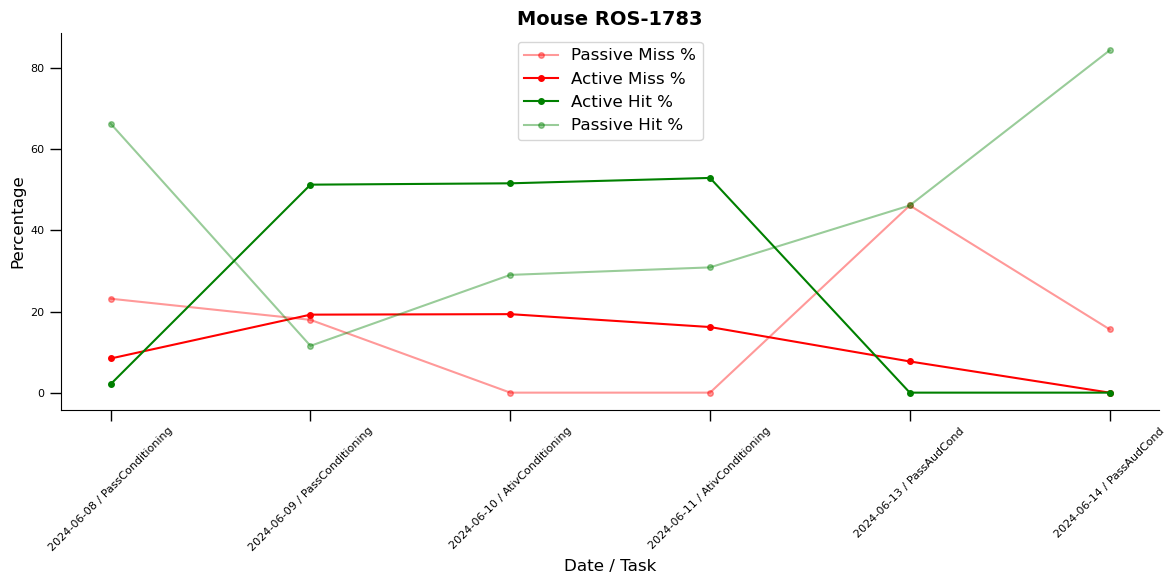

/tmp/ipykernel_698597/449755951.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability


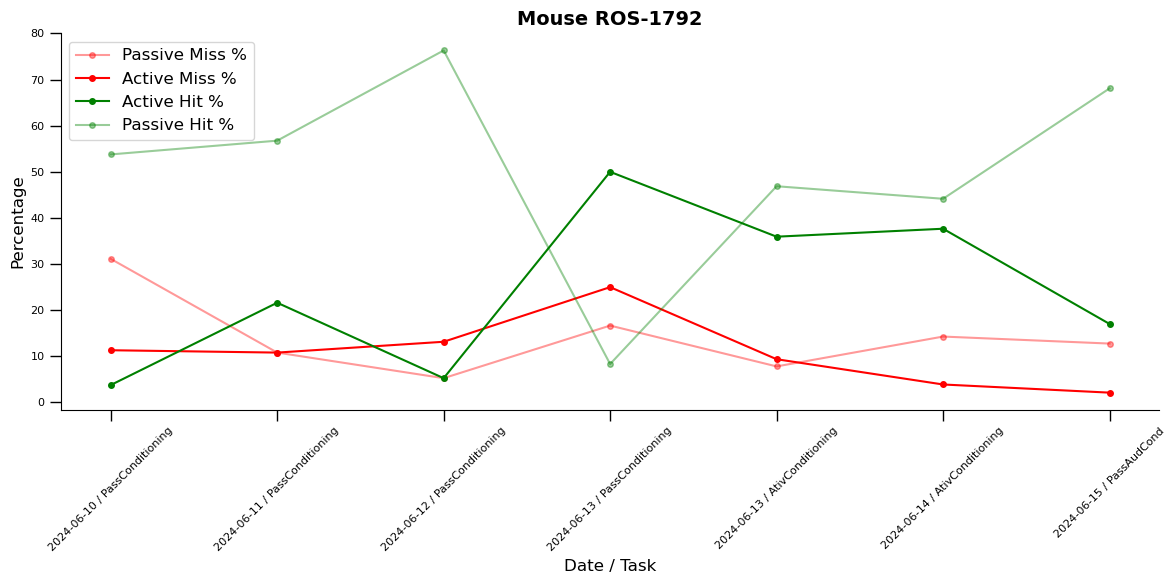

In [164]:
# Create a plot for each mouse
for mouse in mice:
    # Filter data for the current mouse
    mouse_data = learning_df[learning_df['Mouse'] == mouse]
    plt.rcParams['font.family'] = 'sans-serif'
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))  # This also creates an axis object 'ax' which you can use instead of plt directly
    ax.plot(mouse_data['Date_Task'], mouse_data['Passive Miss %'], marker='o', linestyle='-', label='Passive Miss %', color = 'red', alpha=0.4)	
    ax.plot(mouse_data['Date_Task'], mouse_data['Active Miss %'], marker='o', linestyle='-', label='Active Miss %', color = 'red')
    ax.plot(mouse_data['Date_Task'], mouse_data['Active Hit %'], marker='o', linestyle='-', label='Active Hit %', color = 'green')
    ax.plot(mouse_data['Date_Task'], mouse_data['Passive Hit %'], marker='o', linestyle='-', label='Passive Hit %', color = 'green', alpha=0.4)

    # Adding titles and labels
    ax.set_title(f'Mouse {mouse}')
    ax.set_xlabel('Date / Task')
    ax.set_ylabel('Percentage')
    ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability
    ax.legend()
    ax.grid(False)
    fig.tight_layout()

    # Construct the path to the folder where the plot will be saved
    folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning')
    file_path = os.path.join(folder_path, f'learning_curve_{mouse}')

    # Check if the folder exists, and create it if it does not
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Set the background color of the figure to white
    fig.patch.set_facecolor('white')

    # Save and show plot (make sure 'folder_path' and 'file_path' are correctly defined)
    plt.savefig(f'{file_path}.svg')
    plt.savefig(f'{file_path}.png', bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()


# Outcome plot per session

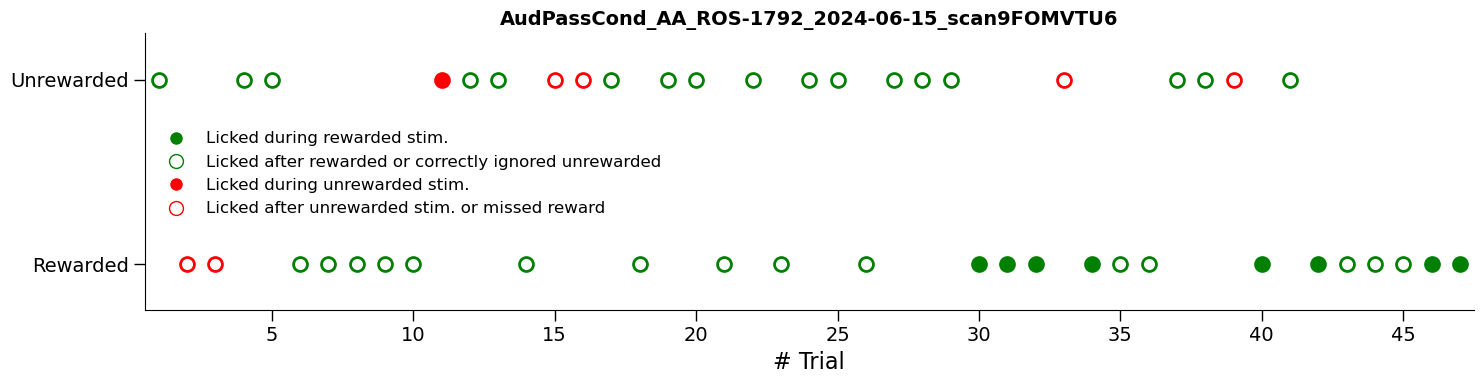

In [27]:
# Plotting setup
fig, ax = plt.subplots(figsize=(15, 4))  # Adjust the figsize to increase width and decrease height

# Define colors and markers based on outcome
color_map = { -1: 'red', 0: 'red', 1: 'green', 2: 'green' }
fill_style_map = { -1: 'none', 0: 'full', 1: 'full', 2: 'none' }

# Plot each point based on its outcome
for idx, row in outcome_df.iterrows():
    ax.plot(row['num_trial'], row['trial_type'], 'o',
            markerfacecolor=color_map[row['outcome']] if fill_style_map[row['outcome']] == 'full' else 'none',
            markeredgecolor=color_map[row['outcome']],
            markeredgewidth=2,
            markersize=10,
            fillstyle=fill_style_map[row['outcome']])

# Adjust y-axis
ax.set_yticks([1, 2])
ax.set_yticklabels(['Unrewarded', 'Rewarded'], fontsize=14)
ax.set_ylim(2.25, 0.75)  # Invert y-axis to place Type 1 on top

# Setting the axis labels and title
ax.set_xlabel('# Trial',fontsize=16)
# ax.set_ylabel('Trial Type')
ax.set_title(scan_info)  # Replace with your actual `scan_info` variable

# Adjust x-axis limits and spacing
ax.set_xlim(0.5, outcome_df['num_trial'].max() + 0.5)  # Provide a little padding
ax.tick_params(axis='x', labelsize=14)

# Create a custom legend using circle markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Licked during rewarded stim.',
           markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Licked after rewarded or correctly ignored unrewarded',
           markerfacecolor='none', markeredgecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Licked during unrewarded stim.',
           markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Licked after unrewarded stim. or missed reward',
           markerfacecolor='none', markeredgecolor='red', markersize=10)
]

# Adjust legend position to avoid overlap and make it visually pleasant
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.4, 0.70), ncol=1, frameon=False)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))


# Show the plot
plt.tight_layout()

# Construct the path to the folder where the plot will be saved
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Outcomes')
file_path = os.path.join(folder_path, f'{scan_info}_outcomes')

# Check if the folder exists, and create it if it does not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
# Save and show plot (make sure 'folder_path' and 'file_path' are correctly defined)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
plt.savefig(f'{file_path}.svg')
plt.savefig(f'{file_path}.png')

plt.show()